# Convolutional Neural Network (CNN)

An automatic genre classification algorithm could greatly increase efficiency for music databases. 

* 1. Data Preprocessing
* 2. Feed Forward Neural Network (FFNN)
* 3. Convolutional Neural Network (CNN)
* 4. Conclusion

This file is created by Geunsik Lim <leemgs@gmail.com>.

* Requirement:
  - Python 3.7.6, Keras 2.3.1, Tensorflow 2.0.1
  - ~/.keras/keras.json 
    - You must use a "image_data_format: **channels_last**" statement.
    - https://keras.io/api/utils/backend_utils/
```bash
$ cat ~/.keras/keras.json
{
    "epsilon": 1e-07,
    "floatx": "float32",
    "image_data_format": "channels_last",
    "backend": "tensorflow"
}
```



## 1. Data Preprocessing
I will use the function "extract_mel_spectrogram" created in the first notebook to get the features and targets. Before constructing the model though, a few additional steps have to be taken:
1. Values of the mel spectrograms should be scaled so that they are between 0 and 1 for computational efficiency.
2. The data is currently 1000 rows of mel spectrograms that are 128 x 660. We need to reshape this to be 1000 rows of 128 x 660 x 1 to represent that there is a single color channel. If our image had three color channels, RGB, we would need this additional dimension to be 3.
3. Target values have to be one-hot-encoded in order to be fed into a neural network.

In [1]:
# !pip install tensorflow==2.0.1
import tensorflow as tf 
print("* Tensorflow", tf.__version__)

tf.keras.backend.image_data_format()

# !pip install keras==2.3.1
import keras
print("* Keras", keras.__version__)

* Tensorflow 2.0.1
* Keras 2.3.1


Using TensorFlow backend.


In [2]:
# Imports
import os
import librosa
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from tensorflow.python.keras import utils
from keras.utils import to_categorical


In [3]:
label_dict = {
    'classical': 0,
    'hiphop': 1,
    'jazz': 2,
    'metal': 3,
    'pop': 4,
    'rock': 5
}

In [4]:
def extract_mel_spectrogram(directory):
    '''
    This function takes in a directory of audio files in .wav format, computes the
    mel spectrogram for each audio file, reshapes them so that they are all the 
    same size, and stores them in a numpy array. 
    
    It also creates a list of genre labels and maps them to numeric values.
    
    Parameters:
    directory (int): a directory of audio files in .wav format
    
    Returns:
    X (array): array of mel spectrogram data from all audio files in the given
    directory
    y (array): array of the corresponding genre labels in numeric form
    '''
    
    # Creating empty lists for mel spectrograms and labels
    labels = []
    mel_specs = []
    
    
    # Looping through each file in the directory
    for file in os.scandir(directory):
        
        # Loading in the audio file
        y, sr = librosa.core.load(file)
        
        # Extracting the label and adding it to the list
        label = str(file).split('.')[0][11:]
        labels.append(label)
        
        # Computing the mel spectrograms
        spect = librosa.feature.melspectrogram(y=y, sr=sr, n_fft=2048, hop_length=1024)
        spect = librosa.power_to_db(spect, ref=np.max)
        
        # Adjusting the size to be 128 x 660
        if spect.shape[1] != 660:
            spect.resize(128,660, refcheck=False)
            
        # Adding the mel spectrogram to the list
        mel_specs.append(spect)
        
    # Converting the list or arrays to an array
    X = np.array(mel_specs)
    
    # Converting labels to numeric values
    labels = pd.Series(labels)

    y = labels.map(label_dict).values
    
    # Returning the mel spectrograms and labels
    return X, y

In [5]:
# Using the function to read and extract mel spectrograms from the GTZAN Genre Dataset audio files
X, y = extract_mel_spectrogram('../data/wavfiles')

In [6]:
# Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify=y, test_size=.2)

**Note:** It is important that we train test split before scaling and reshaping the data to avoid data leakage.

In [7]:
# Checking the minimum value (the scale ranges from zero to some negative value) to see how we should scale the data
X_train.min()

-80.0

In [8]:
# Scaling our data to be between 0 and 1 using the minimum value from above
X_train /= -80
X_test /= -80

In [9]:
# Reshaping images to be 128 x 660 x 1, where the 1 represents the single color channel
X_train = X_train.reshape(X_train.shape[0], 128, 660, 1)
X_test = X_test.reshape(X_test.shape[0], 128, 660, 1)

In [10]:
# One hot encoding our labels
y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)

## 2. Feed Forward Neural Network (FFNN)
Before running a CNN, I wanted to train a feed forward neural network (FFNN) for comparison. CNNs have additional layers for edge detection that make them well suited for image classification problems, but they tend to be more computationally expensive than FFNNs. If a FFNN could perform just as well, there would be no need to use a CNN.

In [11]:
#### FFNN: Model

In [12]:
# Initializing a random seed for replication purposes
np.random.seed(23456)

# Initiating an empty neural network
model = Sequential()

# Adding a flattened layer to input our image data
model.add(Flatten(input_shape = (128, 660, 1)))

# Adding a dense layer with 128 neurons
model.add(Dense(128, activation='relu'))

# Adding a dense layer with 128 neurons
model.add(Dense(128, activation='relu'))

# Adding a dense layer with 64 neurons
model.add(Dense(64, activation='relu'))

# Adding an output layer
model.add(Dense(10, activation='softmax'))

# Compiling our neural network
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])


In [13]:
# Checking the model summary
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 84480)             0         
_________________________________________________________________
dense (Dense)                (None, 128)               10813568  
_________________________________________________________________
dense_1 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_2 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_3 (Dense)              (None, 10)                650       
Total params: 10,838,986
Trainable params: 10,838,986
Non-trainable params: 0
_________________________________________________________________


#### FFNN: Train

In [14]:
_epochs=40
# Fitting our neural network
history = model.fit(X_train,
                    y_train, 
                    batch_size=16,
                    validation_data=(X_test, y_test),
                    epochs=_epochs)

Train on 480 samples, validate on 120 samples
Epoch 1/40
480/480 [==============================] - 2s 4ms/sample - loss: 10.5295 - accuracy: 0.1729 - val_loss: 2.1357 - val_accuracy: 0.2833
Epoch 2/40
480/480 [==============================] - 1s 3ms/sample - loss: 3.1095 - accuracy: 0.2792 - val_loss: 2.9946 - val_accuracy: 0.1750
Epoch 3/40
480/480 [==============================] - 1s 3ms/sample - loss: 2.2357 - accuracy: 0.3333 - val_loss: 1.2985 - val_accuracy: 0.4500
Epoch 4/40
480/480 [==============================] - 1s 3ms/sample - loss: 1.4265 - accuracy: 0.4771 - val_loss: 2.1794 - val_accuracy: 0.3750
Epoch 5/40
480/480 [==============================] - 1s 3ms/sample - loss: 1.7891 - accuracy: 0.4417 - val_loss: 1.1372 - val_accuracy: 0.5250
Epoch 6/40
480/480 [==============================] - 1s 3ms/sample - loss: 1.1505 - accuracy: 0.5458 - val_loss: 1.1205 - val_accuracy: 0.5583
Epoch 7/40
480/480 [==============================] - 1s 3ms/sample - loss: 1.0560 - accu

**Note:** After trying several different architectures, the best model (based on test accuracy) achieved a training score of 69% and a test score of 45%.

#### FFNN: Plot

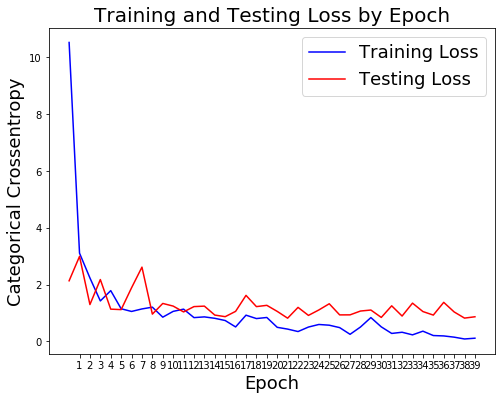

In [15]:
# The code in this cell was adapted from a lecture at General Assembly

# Check out our train loss and test loss over epochs.
train_loss = history.history['loss']
test_loss = history.history['val_loss']

# Set figure size.
plt.figure(figsize=(8, 6))

# Generate line plot of training, testing loss over epochs.
plt.plot(train_loss, label='Training Loss', color='blue')
plt.plot(test_loss, label='Testing Loss', color='red')

# Set title
plt.title('Training and Testing Loss by Epoch', fontsize = 20)
plt.xlabel('Epoch', fontsize = 18)
plt.ylabel('Categorical Crossentropy', fontsize = 18)
plt.xticks(range(1,40), range(1,40))

plt.legend(fontsize = 18);

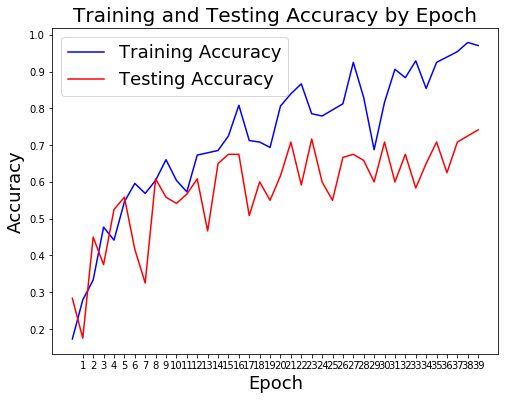

In [16]:
# The code in this cell was adapted from a lecture at General Assembly

# Check out our train accuracy and test accuracy over epochs.
train_loss = history.history['accuracy']
test_loss = history.history['val_accuracy']

# Set figure size.
plt.figure(figsize=(8, 6))

# Generate line plot of training, testing loss over epochs.
plt.plot(train_loss, label='Training Accuracy', color='blue')
plt.plot(test_loss, label='Testing Accuracy', color='red')

# Set title
plt.title('Training and Testing Accuracy by Epoch', fontsize = 20)
plt.xlabel('Epoch', fontsize = 18)
plt.ylabel('Accuracy', fontsize = 18)
plt.xticks(range(1,40), range(1,40))

plt.legend(fontsize = 18);

In [17]:
# Making predictions from the cnn model
fnn_predictions = model.predict(X_test, verbose=0)

#### FFNN: F-Score

In [18]:
# Making precision, recall, and f1-score
#print(classification_report(y_test, fnn_predictions,target_names=label_dict))
print(classification_report(np.argmax(y_test, 1), np.argmax(fnn_predictions, 1),target_names=label_dict))


              precision    recall  f1-score   support

   classical       0.67      0.90      0.77        20
      hiphop       0.71      0.60      0.65        20
        jazz       0.82      0.70      0.76        20
       metal       0.82      0.90      0.86        20
         pop       1.00      0.75      0.86        20
        rock       0.55      0.60      0.57        20

    accuracy                           0.74       120
   macro avg       0.76      0.74      0.74       120
weighted avg       0.76      0.74      0.74       120



## 3. Convolutional Neural Network (CNN

As suspected, the CNN model did much better! The best CNN model (based on test score accuracy) achieved a score of 68%. That’s not too shabby, especially considering the difficulty of the problem, but it still isn’t great. The training score was 84%, so the model was overfit. This means that it was tuning really well to the training data and not generalizing as well to new data. Even so, it’s certainly learning.

#### CNN: Model

In [19]:
# Initializing a random seed for replication purposes
np.random.seed(23456)
tf.random.set_seed(123)

# Initiating an empty neural network
cnn_model = Sequential(name='cnn_1')

# Adding convolutional layer
# https://www.programcreek.com/python/example/89658/keras.layers.Conv2D  ( EXAMPLE 15)
# https://www.programcreek.com/python/example/89662/keras.layers.Convolution2D

cnn_model.add(Conv2D(filters=16,
                     kernel_size=(3,3),
                     activation='relu',
                     input_shape=(128,660,1)))

# Adding max pooling layer
cnn_model.add(MaxPooling2D(pool_size=(2,4)))

# Adding convolutional layer
cnn_model.add(Conv2D(filters=32,
                     kernel_size=(3,3),
                     activation='relu'))

# Adding max pooling layer
cnn_model.add(MaxPooling2D(pool_size=(2,4)))

# Adding a flattened layer to input our image data
cnn_model.add(Flatten())

# Adding a dense layer with 64 neurons
cnn_model.add(Dense(64, activation='relu'))

# Adding a dropout layer for regularization
cnn_model.add(Dropout(0.25))

# Adding an output layer
cnn_model.add(Dense(10, activation='softmax'))

# Compiling our neural network
cnn_model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

# Fitting our neural network
history = cnn_model.fit(X_train,
                        y_train, 
                        batch_size=16,
                        validation_data=(X_test, y_test),
                        epochs=15)

Train on 480 samples, validate on 120 samples
Epoch 1/15
480/480 [==============================] - 9s 18ms/sample - loss: 2.1404 - accuracy: 0.1750 - val_loss: 1.8895 - val_accuracy: 0.1667
Epoch 2/15
480/480 [==============================] - 8s 17ms/sample - loss: 1.8869 - accuracy: 0.2167 - val_loss: 1.6465 - val_accuracy: 0.1667
Epoch 3/15
480/480 [==============================] - 8s 17ms/sample - loss: 1.6235 - accuracy: 0.3604 - val_loss: 1.3456 - val_accuracy: 0.4667
Epoch 4/15
480/480 [==============================] - 8s 17ms/sample - loss: 1.3849 - accuracy: 0.4604 - val_loss: 1.1526 - val_accuracy: 0.4833
Epoch 5/15
480/480 [==============================] - 8s 17ms/sample - loss: 1.1646 - accuracy: 0.5271 - val_loss: 1.0453 - val_accuracy: 0.5333
Epoch 6/15
480/480 [==============================] - 8s 17ms/sample - loss: 0.9592 - accuracy: 0.6167 - val_loss: 0.8037 - val_accuracy: 0.7500
Epoch 7/15
480/480 [==============================] - 8s 17ms/sample - loss: 0.8335 

In [20]:
# Checking the model summary
cnn_model.summary()

Model: "cnn_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 126, 658, 16)      160       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 63, 164, 16)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 61, 162, 32)       4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 30, 40, 32)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 38400)             0         
_________________________________________________________________
dense_4 (Dense)              (None, 64)                2457664   
_________________________________________________________________
dropout (Dropout)            (None, 64)                0     

#### CNN: Train

In [21]:
# Fitting our neural network
_epochs=15
history = cnn_model.fit(X_train,
                        y_train, 
                        batch_size=16,
                        validation_data=(X_test, y_test),
                        epochs=_epochs)

Train on 480 samples, validate on 120 samples
Epoch 1/15
480/480 [==============================] - 8s 17ms/sample - loss: 0.3942 - accuracy: 0.8375 - val_loss: 0.4523 - val_accuracy: 0.8333
Epoch 2/15
480/480 [==============================] - 8s 17ms/sample - loss: 0.2908 - accuracy: 0.9021 - val_loss: 0.5352 - val_accuracy: 0.8250
Epoch 3/15
480/480 [==============================] - 8s 17ms/sample - loss: 0.2360 - accuracy: 0.9271 - val_loss: 0.7537 - val_accuracy: 0.7417
Epoch 4/15
480/480 [==============================] - 8s 17ms/sample - loss: 0.3033 - accuracy: 0.8833 - val_loss: 0.4613 - val_accuracy: 0.8000
Epoch 5/15
480/480 [==============================] - 8s 17ms/sample - loss: 0.2290 - accuracy: 0.9146 - val_loss: 0.4590 - val_accuracy: 0.8333
Epoch 6/15
480/480 [==============================] - 8s 17ms/sample - loss: 0.2746 - accuracy: 0.9083 - val_loss: 0.4993 - val_accuracy: 0.8083
Epoch 7/15
480/480 [==============================] - 8s 17ms/sample - loss: 0.1843 

#### CNN: Plot

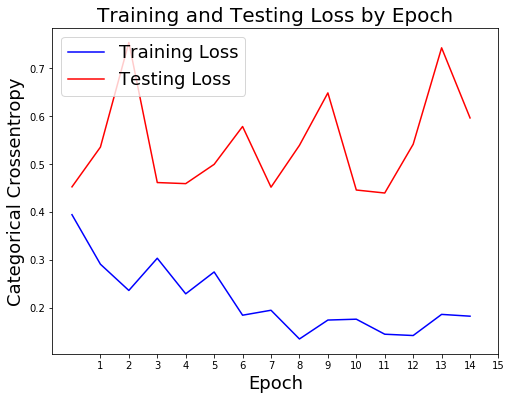

In [22]:
# The code in this cell was adapted from a lecture at General Assembly

# Check out our train loss and test loss over epochs.
train_loss = history.history['loss']
test_loss = history.history['val_loss']

# Set figure size.
plt.figure(figsize=(8, 6))

# Generate line plot of training, testing loss over epochs.
plt.plot(train_loss, label='Training Loss', color='blue')
plt.plot(test_loss, label='Testing Loss', color='red')

# Set title
plt.title('Training and Testing Loss by Epoch', fontsize = 20)
plt.xlabel('Epoch', fontsize = 18)
plt.ylabel('Categorical Crossentropy', fontsize = 18)
plt.xticks(range(1,16), range(1,16))

plt.legend(fontsize = 18);

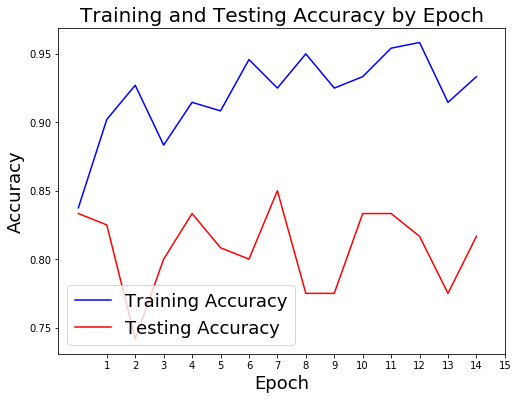

In [23]:
# The code in this cell was adapted from a lecture at General Assembly

# Check out our train accuracy and test accuracy over epochs.
train_loss = history.history['accuracy']
test_loss = history.history['val_accuracy']

# Set figure size.
plt.figure(figsize=(8, 6))

# Generate line plot of training, testing loss over epochs.
plt.plot(train_loss, label='Training Accuracy', color='blue')
plt.plot(test_loss, label='Testing Accuracy', color='red')

# Set title
plt.title('Training and Testing Accuracy by Epoch', fontsize = 20)
plt.xlabel('Epoch', fontsize = 18)
plt.ylabel('Accuracy', fontsize = 18)
plt.xticks(range(1,16), range(1,16))

plt.legend(fontsize = 18);

**Note:** Most of the models I ran became increasingly overfit after about 15-20 epochs, so increasing the number of epochs would likely not improve the model.

In [24]:
# Making predictions from the cnn model
predictions = cnn_model.predict(X_test, verbose=0)

#### CNN: Confusion Matrix
To look deeper into what was happening with the model, I computed a confusion matrix to visualize the model's predictions against the actual values.

**Note:** since the confusion matrix function from sklearn does not return the labels for predicted values and actual values, I checked how many predicted and actual values there were for each genre to be able to figure it out.

In [25]:
# Checking the number of targets per class
for i in range(6): 
    print(f'{i}: {sum([1 for target in y_test if target[i] == 1])}')

0: 20
1: 20
2: 20
3: 20
4: 20
5: 20


In [26]:
# Checking the number of predicted values in each class
for i in range(6): 
    print(f'{i}: {sum([1 for prediction in predictions if np.argmax(prediction) == i])}')

0: 18
1: 29
2: 22
3: 21
4: 17
5: 13


In [27]:
# Calculating the confusion matrix 
# row: actual
# columns: predicted
conf_matrix = confusion_matrix(np.argmax(y_test, 1), np.argmax(predictions, 1))
conf_matrix

array([[16,  0,  3,  0,  0,  1],
       [ 0, 20,  0,  0,  0,  0],
       [ 1,  0, 18,  0,  1,  0],
       [ 0,  0,  0, 20,  0,  0],
       [ 0,  6,  0,  0, 13,  1],
       [ 1,  3,  1,  1,  3, 11]])

In [28]:
# Creating a dataframe of the confusion matrix with labels for readability 
confusion_df = pd.DataFrame(conf_matrix)
confusion_df

,0,1,2,3,4,5
0,16,0,3,0,0,1
1,0,20,0,0,0,0
2,1,0,18,0,1,0
3,0,0,0,20,0,0
4,0,6,0,0,13,1
5,1,3,1,1,3,11


In [29]:
# Renaming rows and columns with labels
confusion_df = confusion_df.rename(columns=label_dict)
confusion_df.index = confusion_df.columns
confusion_df

,0,1,2,3,4,5
0,16,0,3,0,0,1
1,0,20,0,0,0,0
2,1,0,18,0,1,0
3,0,0,0,20,0,0
4,0,6,0,0,13,1
5,1,3,1,1,3,11


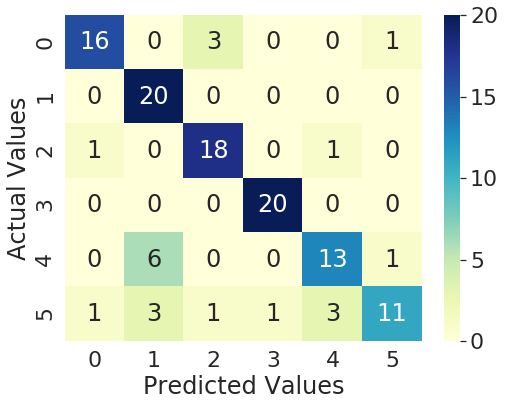

In [30]:
# Creating a heatmap for the confusion matrix for display
plt.figure(figsize= (8,6))
sns.set(font_scale = 2);
ax = sns.heatmap(confusion_df,   annot=True, cmap="YlGnBu");
ax.set(xlabel='Predicted Values', ylabel='Actual Values');

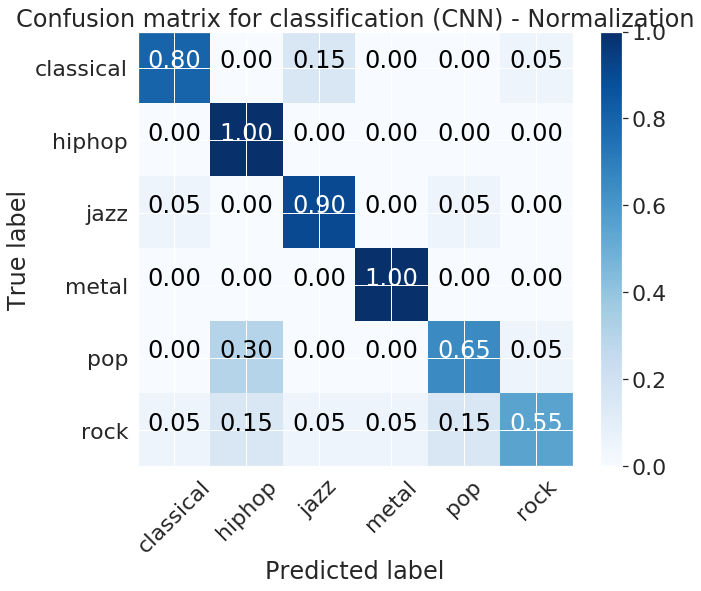

In [31]:
import itertools
# Helper to plot confusion matrix -- from Scikit-learn website
def plot_confusion_matrix_02(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.figure(figsize= (10, 8))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()
    
plot_confusion_matrix_02(conf_matrix, label_dict, normalize=True, title="Confusion matrix for classification (CNN) - Normalization")

#### CNN: F1-Score

In [32]:
# Making precision, recall, and f1-score
print(classification_report(np.argmax(y_test, 1), np.argmax(predictions, 1),target_names=label_dict))

              precision    recall  f1-score   support

   classical       0.89      0.80      0.84        20
      hiphop       0.69      1.00      0.82        20
        jazz       0.82      0.90      0.86        20
       metal       0.95      1.00      0.98        20
         pop       0.76      0.65      0.70        20
        rock       0.85      0.55      0.67        20

    accuracy                           0.82       120
   macro avg       0.83      0.82      0.81       120
weighted avg       0.83      0.82      0.81       120



## 4. Conclusion

I tried several different architectures to improve the F1-score of 6 genres. From my experiment, I could get F1-score until 83% with my CNN model. Most of the models became increasingly overfit after about 15-20 epochs, so increasing the number of epochs likely would not improve the model.



In [33]:
print ("The tasks (FFNN and CNN) is successfully completed.")

The tasks (FFNN and CNN) is successfully completed.
